In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas

In [2]:
COMPUTED_PATH = '../../data/computed/worldwide'
LOCAL_DATA_SOURCES_PATH = '../../data/sources/worldwide'
WORLDWIDE_BASE_NAME = 'worldwide_base_{}.pickle'
METADATA_BASE_NAME = 'metadata_{}.pickle'

In [3]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [4]:
def group_by_dimension(df, dimension_key, dimension_value):
    gt = df.groupby(by=dimension_key).sum()
    df = df.drop(df[df[dimension_key]==dimension_value].index)
    df = df.append(
        gt.iloc[gt.index.get_level_values(dimension_key)==dimension_value].reset_index()
    ).reset_index()
    
    df.drop(['index'], axis=1, inplace=True)
    
    return df

In [5]:
def get_raw_data(url, value_name, groupby_countries = [], groupby_provinces = False):

    df = pd.read_csv(url)

    df.drop(
        ['Lat', 'Long', 'Long_', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Population'], 
        axis=1, inplace=True, errors='ignore'
    )

    df.rename(
        columns = {
            'Province/State':'province_state', 
            'Country/Region': 'country_region',
            'Province_State':'province_state', 
            'Country_Region': 'country_region',
        },
        inplace=True,
        errors='ignore'
    )

    # remove this fancy province "Recovered"
    df.drop(df[df.province_state == 'Recovered'].index, inplace=True)
        
    for country in groupby_countries:
        df = group_by_dimension(df, dimension_key='country_region', dimension_value=country)

    if groupby_provinces:
        df = df.groupby(['province_state', 'country_region'], as_index=False).sum().reset_index(drop=True)
        
    # pivot the columns as we want timeseries
    df = pd.melt(
        df, 
        id_vars=['province_state', 'country_region'], 
        value_name=value_name,
        var_name='date'
    )

    df['date'] = pd.to_datetime(df['date'])

    df.set_index(['country_region', 'province_state', 'date'], inplace=True)
    
    df.sort_index(inplace=True)
    
    return df

# COVID-19 datasets

## process global datasets

credits https://github.com/CSSEGISandData/COVID-19

The following datasets are timeseries with dates on columns and country_region/province_state on the rows:
- `time_series_covid19_confirmed_global.csv`
- `time_series_covid19_deaths_global.csv`
- `time_series_covid19_recovered_global.csv`

Lets process them through the following steps:
1. discard the `time_series_covid19_recovered_global.csv` dataset:
  - it suffers most from detection errors
  - it is not available at the state level for Canada and US
2. unpivot the other two datasets in order to have the dates on the rows in a multiindex with the regions
3. merge the 2 unpivoted datasets on the multiindex to obtain a single dataset `global_series` with the following columns:
  - index:
    - country_region
    - province_state
    - date
  - value columns:
    - confirmed
    - deaths
4. remove the US from the dataset as other files must be used to obtain state level data (see below)

In [6]:
groupby_countries=[]

url_global_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_confirmed = get_raw_data(url=url_global_confirmed, value_name='confirmed', groupby_countries=groupby_countries)
print('global_confirmed: {}'.format(global_confirmed.shape))

url_global_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_deaths = get_raw_data(url=url_global_deaths, value_name='deaths', groupby_countries=groupby_countries)
print('global_deaths: {}'.format(global_deaths.shape))    

# Merge the 2 datasets

global_series = global_confirmed.merge(
    global_deaths, how='outer', left_index=True, right_index=True
)

global_series.sort_index(inplace=True)

# drop the US
global_series.drop(index='US', inplace=True)

print('global_series (no US): {}'.format(global_series.shape))  

# make sure we have no NaN after joining
assert global_series[global_series.confirmed.isna()].shape[0] == 0
assert global_series[global_series.deaths.isna()].shape[0] == 0

global_confirmed: (89972, 1)
global_deaths: (89972, 1)
global_series (no US): (89640, 2)


## process US datasets

credits https://github.com/CSSEGISandData/COVID-19

The following datasets are timeseries with dates on columns and country_region/province_state on the rows:
- `time_series_covid19_confirmed_US.csv`
- `time_series_covid19_deaths_US.csv`

Lets process them through the following steps:
1. group by on the province dimension as we are interested in aggregations at the state level
2. unpivot the datasets in order to have the dates on the rows in a multiindex with the regions
3. merge the 2 unpivoted datasets on the multiindex to obtain a single dataset `global_series` with the following columns:
  - index:
    - country_region
    - province_state
    - date
  - value columns:
    - confirmed
    - deaths

In [7]:
url_US_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_confirmed = get_raw_data(url_US_confirmed, value_name='confirmed', groupby_provinces=True)
print('US_confirmed: {}'.format(US_confirmed.shape))

url_US_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_deaths = get_raw_data(url_US_deaths, value_name='deaths', groupby_provinces=True)
print('US_confirmed: {}'.format(US_deaths.shape))  

# Merge the 2 datasets

US_series = US_confirmed.merge(
    US_deaths, how='outer', left_index=True, right_index=True
)

US_series.sort_index(inplace=True)

print('US_series: {}'.format(US_series.shape))  

# make sure we have no NaN after joining
assert US_series[US_series.confirmed.isna()].shape[0] == 0
assert US_series[US_series.deaths.isna()].shape[0] == 0

US_confirmed: (19256, 1)
US_confirmed: (19256, 1)
US_series: (19256, 2)


## append global and US datasets

In [8]:
global_covid_series = pd.concat([global_series, US_series])
print('global_covid_series (with US): {}'.format(global_covid_series.shape)) 

assert global_covid_series.shape[0] == global_series.shape[0]+US_series.shape[0]

global_covid_series (with US): (108896, 2)


## plot something

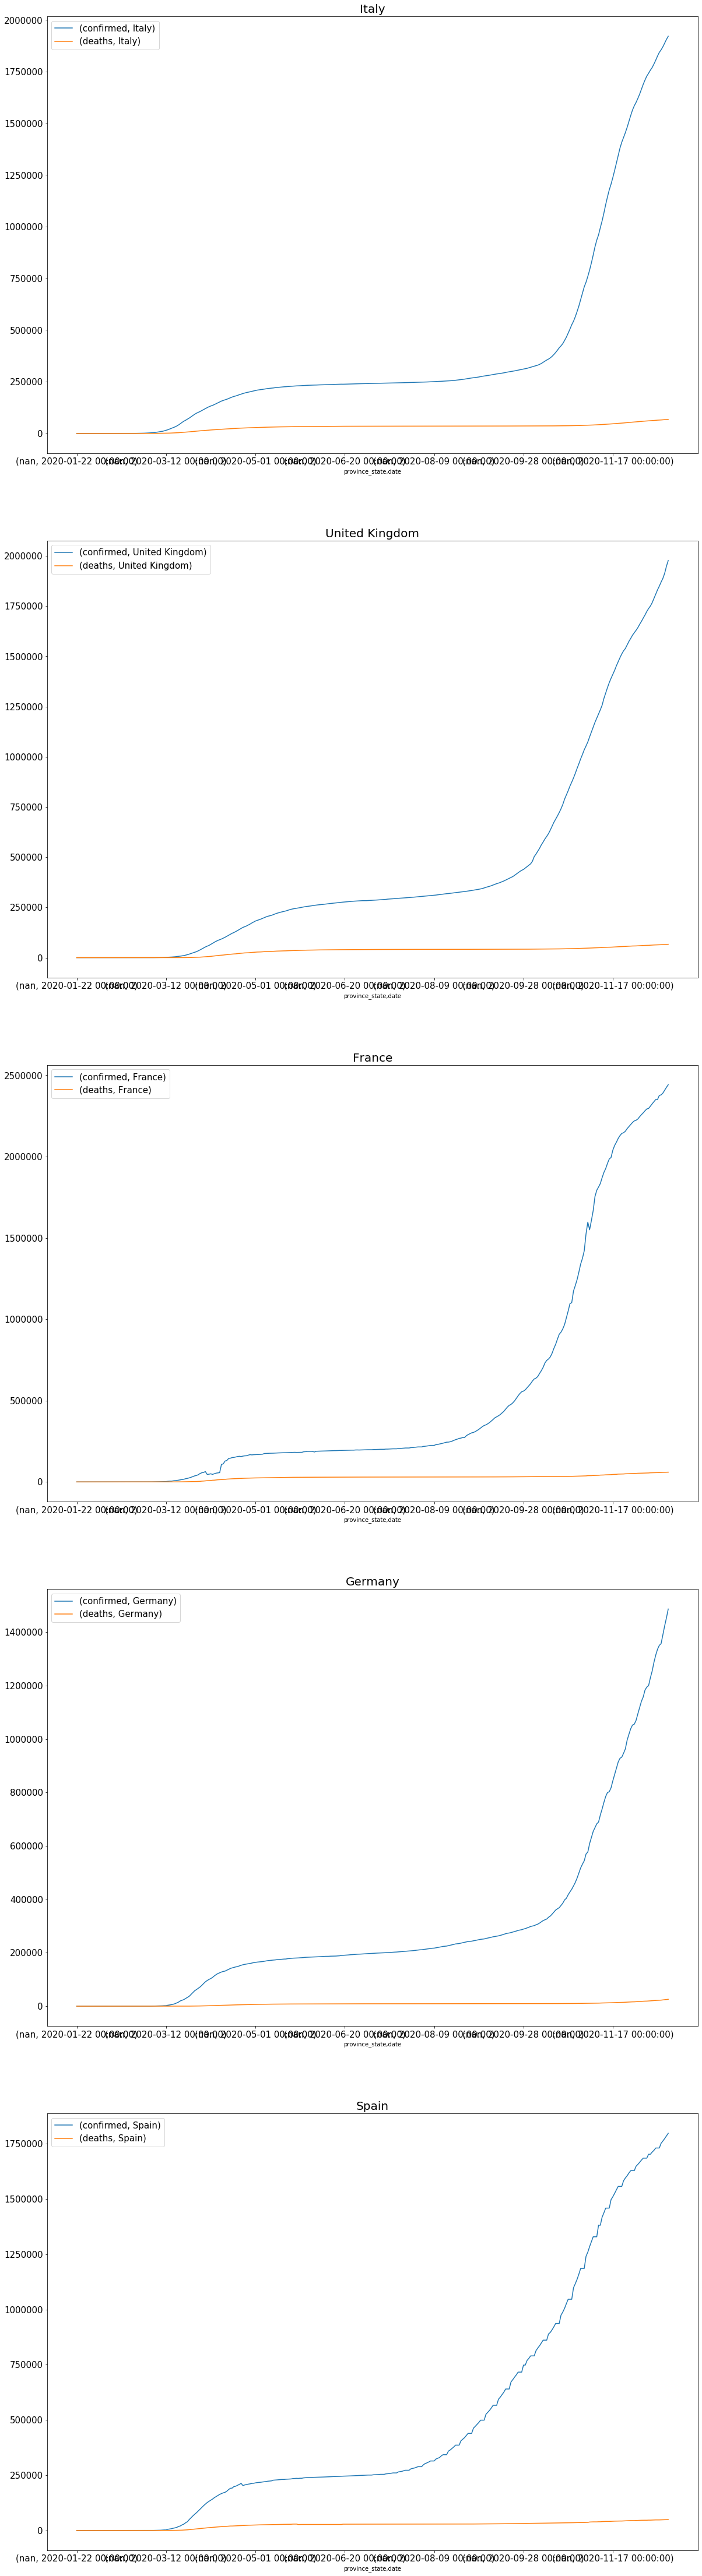

In [9]:
countries = ['Italy', 'United Kingdom', 'France', 'Germany', 'Spain']
selected_countries = global_covid_series.iloc[
    global_covid_series.index.get_level_values('country_region').isin(countries) &
    global_covid_series.index.get_level_values('province_state').isna()
]
f, a = plt.subplots(len(countries), figsize=(20,80))                  
for country in countries:
    ax = a[countries.index(country)]
    
    selected_countries.iloc[
        selected_countries.index.get_level_values('country_region') == country
    ].unstack(level=0).plot(ax=a[countries.index(country)], fontsize=15, title=country)
    ax.title.set_size(20)
    ax.legend(fontsize=15)

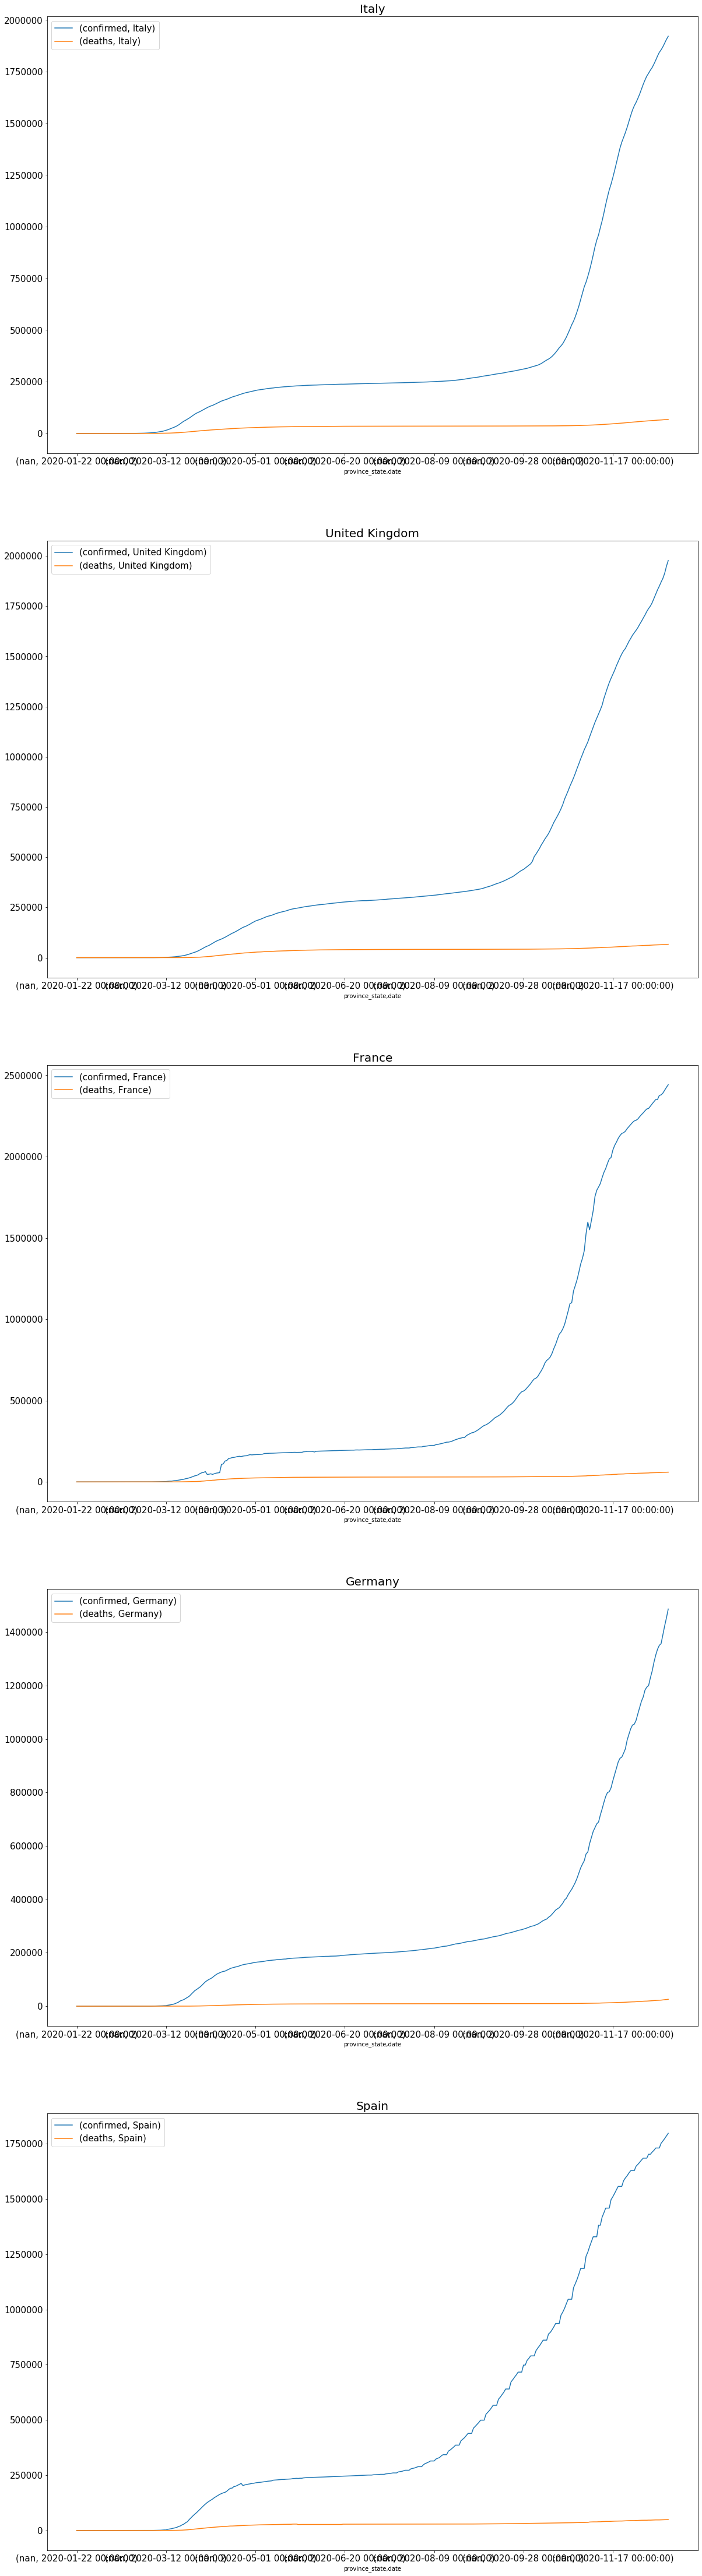

In [10]:
countries = ['Italy', 'United Kingdom', 'France', 'Germany', 'Spain']
selected_countries = global_covid_series.iloc[
    global_covid_series.index.get_level_values('country_region').isin(countries) &
    global_covid_series.index.get_level_values('province_state').isna()
]
f, a = plt.subplots(len(countries), figsize=(20,80))                  
for country in countries:
    ax = a[countries.index(country)]
    
    selected_countries.iloc[
        selected_countries.index.get_level_values('country_region') == country
    ].unstack(level=0).plot(ax=a[countries.index(country)], fontsize=15, title=country)
    ax.title.set_size(20)
    ax.legend(fontsize=15)

# Mobility data

## process mobility data

Google LLC "Google COVID-19 Community Mobility Reports."

https://www.google.com/covid19/mobility/ Accessed: May 1 2020.
    
    
Processing:

1. for United States, Canada, Australia:
  - keep rows with `(sub_region_1 != NaN) and (sub_region_2 == NaN)` as we need state level aggregation
2. for all other countries:
  - keep rows with `sub_region_1 == NaN` as we need country level aggregation (e.g. Italy, France, etc)

In [11]:
global_mobility = pd.read_csv(
    'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv',
     parse_dates=['date'],
     dtype={'sub_region_2':str, 'metro_area': str}
)

temp_state_level = global_mobility.loc[
    (global_mobility.country_region.isin(['United States', 'Canada', 'Australia'])) &
    (global_mobility.sub_region_1.isna() == False) &
    (global_mobility.sub_region_2.isna() == True)
]

temp_country_level = global_mobility.loc[
    (global_mobility.country_region.isin(['United States', 'Canada', 'Australia']) == False) &
    (global_mobility.sub_region_1.isna() == True)
]

global_mobility = pd.concat([temp_state_level, temp_country_level])

global_mobility.drop(
    columns=[
        'sub_region_2', 
        'metro_area',
        'country_region_code',
        'iso_3166_2_code', 
        'census_fips_code'], inplace=True
)

global_mobility.rename(columns = {'sub_region_1':'province_state'}, inplace=True, errors='ignore')

global_mobility.set_index(['country_region', 'province_state', 'date'], inplace=True)

# Merge COVID-19 and mobility data

##  fix some country / region names on both datasets

1. modify Country/Region hierarchies and names as:
  - some Country/Regions hierarchies are managed differently in the two datasets
  - some Countries have sligthly different names
2. compare the Country/Region part of the indexes of the two datasets to ensure the fixes have the desired effect
   - check if `global_mobility` index labels are present in the `global_covid_series` (as `global_mobility` as fewer countries/regions than `global_covd_series`
   - only the following Countries/Regions will be left out:
     - Canada, Nunavut
     - Myanmar (Burma)
     - Puerto Rico

### fixes on `global_mobility`

In [12]:
def update_index(df, country_region_old, country_region_new, state_province_old, state_province_new):
    tempdf = df.loc[df.index.get_level_values('country_region')==country_region_old].rename(
        index={country_region_old: country_region_new, state_province_old: state_province_new}
    )
    df.drop(index=country_region_old, inplace=True, level='country_region')
    df = pd.concat([df, tempdf])
    return df


global_mobility = update_index(
    global_mobility,
    country_region_old='Hong Kong',
    country_region_new='China',
    state_province_old=np.nan,
    state_province_new='Hong Kong'
)

global_mobility = update_index(
    global_mobility,
    country_region_old='Aruba',
    country_region_new='Netherlands',
    state_province_old=np.nan,
    state_province_new='Aruba'
)

global_mobility = update_index(
    global_mobility,
    country_region_old='Réunion',
    country_region_new='France',
    state_province_old=np.nan,
    state_province_new='Reunion'
)


# rename countries for naming compatibility
global_mobility.rename(
    index={
        'Cape Verde': 'Cabo Verde',
        'Côte d\'Ivoire': 'Cote d\'Ivoire'
    }, inplace=True
)

global_mobility.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)

#### drop missing countries/regions from `global_mobility`

- the two datasets will be merged starting from the `global_mobility` and looking up corresponding records in the `global_covid_series`

- countries/regions which are present in the `global_mobility` and not in the `global_covid_series` are dropped from the `global_mobility`


In [13]:
drop_countries = pd.MultiIndex.from_tuples(
    [
        ('Canada', 'Nunavut'), 
        ('Canada', 'Yukon'), 
        ('Myanmar (Burma)', np.nan), 
        ('Puerto Rico', np.nan),
        ('Laos', np.nan)
    ],
    names=['country_region', 'province_state']
)

global_mobility.reset_index(inplace=True)
global_mobility.set_index(['country_region', 'province_state'], inplace=True)
global_mobility.drop(index=drop_countries, inplace=True)

global_mobility.reset_index(inplace=True)
global_mobility.set_index(['country_region', 'province_state', 'date'], inplace=True)
global_mobility.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)

mobility_region_index = global_mobility.index.droplevel('date').unique()

print('global_mobility: {}'.format(global_mobility.shape))

global_mobility: (79523, 6)


### fixes on `global_covid_series`

In [14]:
index_mapper = {
    'US': 'United States',
    'Korea, South': 'South Korea',
    'Taiwan*': 'Taiwan',
    'Bahamas': 'The Bahamas'
}

global_covid_series.rename(index=index_mapper, inplace=True)

global_covid_series.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)

covid_region_index = global_covid_series.index.droplevel('date').unique()

## assert consistency conditions

In [15]:
mismatch_countries = pd.MultiIndex.from_tuples(
    [],
    names=['country_region', 'province_state']
)

assert (mobility_region_index.difference(covid_region_index) == mismatch_countries).all()

## finally, merge the two datasets

In [16]:
# convert np.nan into strings as merge is not happy with strings and nan together

global_mobility.index = pd.MultiIndex.from_tuples(
    [tuple('nan' if pd.isna(l) else l for l in ix) for ix in global_mobility.index.to_list()],
    names=['country_region', 'province_state', 'date']
)
global_covid_series.index = pd.MultiIndex.from_tuples(
    [tuple('nan' if pd.isna(l) else l for l in ix) for ix in global_covid_series.index.to_list()],
    names=['country_region', 'province_state', 'date']
)

# sort and merge
global_mobility.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)
global_covid_series.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)

covid_mobility_df = global_mobility.merge(
    global_covid_series, how='inner', left_index=True, right_index=True
)

covid_mobility_df.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)


# get the np.nan back istead of strings
covid_mobility_df.index = pd.MultiIndex.from_tuples(
    [tuple(np.nan if l=='nan' else l for l in ix) for ix in covid_mobility_df.index.to_list()],
    names=['country_region', 'province_state', 'date']
)

# plot Italy

In [17]:
italy = covid_mobility_df.loc[covid_mobility_df.index.get_level_values('country_region')=='Italy']

No handles with labels found to put in legend.


['2020-10-27', '2020-02-15', '2020-04-05', '2020-05-25', '2020-07-14', '2020-09-02', '2020-10-22', '2020-12-11']


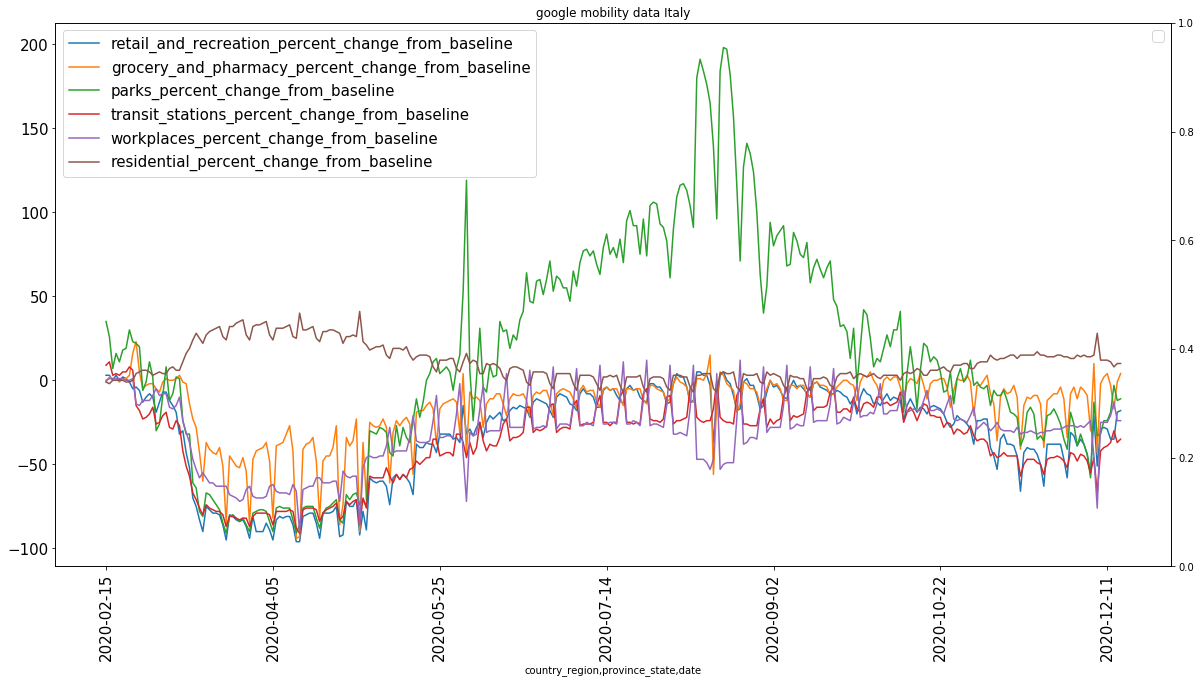

In [18]:
ax1 = italy.loc[:,[col for col in italy.columns if 'baseline' in col]].plot(figsize=(20,10), fontsize=15, title='google mobility data Italy')
date_labels = [t.get_text().split(' ')[2] for t in ax1.get_xticklabels() if len(t.get_text().split(' '))>2]
print(date_labels)
ax1.legend(fontsize=15)
ax1.set_xticklabels(date_labels, rotation=90)
#date_labels = [v for i, v in enumerate(date_labels) if i in ax1.get_xticks()]
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
#italy.loc[:,[col for col in italy.columns if 'baseline' not in col]].plot(ax=ax2, fontsize=30)
ax2.legend(fontsize=15)
#ax2.set_xticklabels(date_labels, rotation=90)

# save everything

In [19]:
DATA_DATE = str(covid_mobility_df.index.droplevel(['country_region', 'province_state']).max()).split(' ')[0]

In [20]:
print('DATA_DATE: {}'.format(DATA_DATE))

DATA_DATE: 2020-12-15


In [21]:
covid_mobility_df.to_pickle(os.path.join(COMPUTED_PATH, WORLDWIDE_BASE_NAME.format(DATA_DATE)))

# Get the population data

source: https://population.un.org/wpp/Download/Standard/CSV/

In [22]:
WORLD_POPULATION_DATA_URL = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv'

pop_data = pd.read_csv(WORLD_POPULATION_DATA_URL)

pop_data = pop_data[pop_data.Time == 2016]

pop_data.rename(columns={'Location': 'country_region'}, inplace=True)
pop_data['province_state'] = np.nan

pop_data.set_index(['country_region', 'province_state'], inplace=True)

print('pop_data.shape: {}'.format(pop_data.shape))

pop_data.shape: (477, 9)


In [23]:
pop_data.rename(
    index={
        'Bahamas': 'The Bahamas',
        'Côte d\'Ivoire': 'Cote d\'Ivoire',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Republic of Moldova': 'Moldova',
        'Republic of Korea': 'South Korea',
        'China, Taiwan Province of China': 'Taiwan',
        'United Republic of Tanzania': 'Tanzania',
        'Venezuela (Bolivarian Republic of)': 'Venezuela',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia'
    }, 
    inplace=True
)

pop_data.drop(index=('United States of America', np.nan), inplace=True)

In [24]:
pop_data.PopTotal = pop_data.PopTotal*1000

## US population data by states

In [25]:
US_POPULATION_DATA_URL = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2016/state/asrh/scprc-est2016-18+pop-res.csv'
#'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv'

us_pop_data = pd.read_csv(US_POPULATION_DATA_URL)

us_pop_data.rename(columns={'NAME': 'province_state'}, inplace=True)
us_pop_data['country_region'] = 'United States'

us_pop_data.set_index(['country_region', 'province_state'], inplace=True)

In [26]:
temp_us_covid_mobility = covid_mobility_df.loc[covid_mobility_df.index.get_level_values('country_region')=='United States']
temp_us_covid_mobility.reset_index(inplace=True)
temp_us_covid_mobility.set_index(['country_region','province_state','date'], inplace=True)

assert(len(temp_us_covid_mobility.index.droplevel('date').difference(us_pop_data.index))==0)

In [27]:
us_pop_data.POPESTIMATE2016 = us_pop_data.POPESTIMATE2016.astype(float)

## append world and US

In [28]:
world_population = pd.concat(
    [
        pop_data.loc[:,['PopTotal']].rename(columns={'PopTotal': 'population_estimate_2016'}),
        us_pop_data.loc[:,['POPESTIMATE2016']].rename(columns={'POPESTIMATE2016': 'population_estimate_2016'})
    ]
)

## Fix some dependencies

In [29]:
world_population = update_index(
    world_population,
    country_region_old='Aruba',
    country_region_new='Netherlands',
    state_province_old=np.nan,
    state_province_new='Aruba'
)

world_population = update_index(
    world_population,
    country_region_old='Réunion',
    country_region_new='France',
    state_province_old=np.nan,
    state_province_new='Reunion'
)

world_population = update_index(
    world_population,
    country_region_old='China, Hong Kong SAR',
    country_region_new='China',
    state_province_old=np.nan,
    state_province_new='Hong Kong'
)


## Australia population data

https://datapacks.censusdata.abs.gov.au/datapacks/

In [30]:
from collections import OrderedDict
au_pop = OrderedDict({
    'Australian Capital Territory': 397397.,
    'New South Wales': 7480228.,
    'Northern Territory': 228833.,
    'Queensland': 4703193.,
    'South Australia': 1676653.,
    'Tasmania': 509965.,
    'Victoria': 5926624.,
    'Western Australia': 2474410.
})

In [31]:
au_pop_data = pd.DataFrame.from_dict(
    {
        'country_region': 'Australia',
        'province_state': list(au_pop.keys()),
        'population_estimate_2016': list(au_pop.values())
    }
)

au_pop_data.set_index(['country_region', 'province_state'], inplace=True)

In [32]:
world_population = pd.concat(
    [
        world_population,
        au_pop_data
    ]
)

## Canada population data

https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E

In [33]:
CANADA_POPULATION_DATA_URL = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/GetFile.cfm?Lang=E&FILETYPE=CSV&GEONO=059'
can_pop_data = pd.read_csv(os.path.join(LOCAL_DATA_SOURCES_PATH, '98-401-X2016059_English_CSV_data.csv'))

In [34]:
can_pop_data = can_pop_data.loc[
    (can_pop_data['DIM: Profile of Canada, Provinces and Territories (2247)']=='Population, 2016') &
    (can_pop_data['GEO_CODE (POR)'] != 1),
    ['GEO_NAME', 'Dim: Sex (3): Member ID: [1]: Total - Sex']
].rename(columns={
    'GEO_NAME': 'province_state',
    'Dim: Sex (3): Member ID: [1]: Total - Sex': 'population_estimate_2016'
})

can_pop_data['country_region'] = 'Canada'
can_pop_data.set_index(['country_region', 'province_state'], inplace=True)

In [35]:
can_pop_data.population_estimate_2016 = can_pop_data.population_estimate_2016.astype(float)

In [36]:
world_population = pd.concat(
    [
        world_population,
        can_pop_data
    ]
)

## check referential integrity

In [37]:
covid_mobility_df_index = covid_mobility_df.index.droplevel('date')
try:
    assert(len(covid_mobility_df_index.difference(world_population.index))==0)
except:
    print(covid_mobility_df_index.difference(world_population.index))
    raise

# Get latitude and longitude

credits https://github.com/CSSEGISandData/COVID-19

In [38]:
def get_lat_long(url, mapper=None):
    df= pd.read_csv(url)

    df.rename(
        columns = {
            'Province/State':'province_state', 
            'Country/Region': 'country_region',
            'Province_State':'province_state', 
            'Country_Region': 'country_region',
            'Long_': 'Long'
        },
        inplace=True,
        errors='ignore'
    )

    df.set_index(['country_region', 'province_state'], inplace=True)
    if mapper:
        df.rename(index=mapper, inplace=True)
    df.sort_index(inplace=True)
    df = df[['Lat', 'Long']]
    return df

In [39]:
global_lat_long = get_lat_long(url_global_confirmed, index_mapper)
global_lat_long = global_lat_long[(global_lat_long.Lat!=0.0) & (global_lat_long.Long != 0.0)]

global_lat_long.drop(index=('United States', np.nan), inplace=True)

us_lat_long = get_lat_long(url_US_confirmed, index_mapper)

## US States centroids

we need to find the centroids for US states, as the coordinates are given at the county level

In [40]:
us_lat_long_clean = us_lat_long[(us_lat_long.Lat!=0.0) & (us_lat_long.Long != 0.0)]
geo_us_lat_long = geopandas.GeoDataFrame(
    us_lat_long_clean, 
    geometry=geopandas.points_from_xy(us_lat_long_clean.Long, us_lat_long_clean.Lat)
)

states = geo_us_lat_long.dissolve(by=['country_region', 'province_state'])
states['Long'] = states.geometry.centroid.x
states['Lat'] = states.geometry.centroid.y
states.drop(columns=['geometry'], inplace=True)

In [41]:
lat_long_df = pd.concat([global_lat_long, states])

lat_long_df.sort_index(inplace=True)

# Merge population and geo data into a metadata dataframe

In [42]:
metadata_df = lat_long_df.drop(index= lat_long_df.index.difference(world_population.index)).merge(
    world_population.drop(index=world_population.index.difference(lat_long_df.index)), 
    how='inner', left_index=True, right_index=True
)


metadata_df.sort_index(level=['country_region', 'province_state'], inplace=True)

In [43]:
assert(len(covid_mobility_df_index.difference(metadata_df.index))==0)

## save metadata

In [44]:
metadata_df.to_pickle(os.path.join(COMPUTED_PATH, METADATA_BASE_NAME.format(DATA_DATE)))

# Recap

In [45]:
print('global_covid_series countries/regions: {}'.format(
    global_covid_series.index.droplevel('date').unique().shape
))

global_covid_series countries/regions: (328,)


In [46]:
print('global_mobility countries/regions: {}'.format(
    global_mobility.index.droplevel('date').unique().shape
))

global_mobility countries/regions: (199,)


In [47]:
print('covid_mobility_df countries/regions: {}'.format(
    covid_mobility_df.index.droplevel('date').unique().shape
))

covid_mobility_df countries/regions: (199,)


In [48]:
print('metadata_df countries/regions: {}'.format(
    metadata_df.index.unique().shape
))

metadata_df countries/regions: (251,)


In [49]:
global_mobility.columns

Index(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')